In [1]:
import subprocess
import os 

In [2]:
from huggingface_hub import snapshot_download
import cv2 
import dotenv 
dotenv.load_dotenv()
import numpy as np
import gradio as gr
import glob
from inference import inference_frame,inference_frame_serial
from inference import inference_frame_par_ready
from inference import process_frame
import os
import pathlib
import multiprocessing as mp
from time import time


REPO_ID='SharkSpace/videos_examples'
snapshot_download(repo_id=REPO_ID, token=os.environ.get('SHARK_MODEL'),repo_type='dataset',local_dir='videos_example')


torch version: 2.0.0+cu117 cuda: True


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loads checkpoint by local backend from path: model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/checkpoint_v2.pth


{'type': 'DetLocalVisualizer', 'vis_backends': [{'type': 'LocalVisBackend'}], 'name': 'visualizer'}
07/25 07:56:57 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dataset_meta', '_draw_instances', '_draw_panoptic_seg', '_init_manager', '_initialize_fig', '_instance_dict', '_instance_name', '_is_posion_valid', '_vis_backends', 'add_config', 'add_datasample', 'add_graph', 'add_image', 'add_scalar', 'add_scalars', 'alpha', 'ax_save', 'bbox_color', 'check_instance_created', 'close', 'dataset_meta', 'dpi', 'draw_bboxes', 'draw_binary_masks', 'draw_circles', 'draw_featmap', 'draw_lines', 'draw_points', 'draw_po

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

'/home/afengler/proj_shark/huggingface/shark_detection/videos_example'

In [3]:
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
import os
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS

from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download
from time import time

classes= ['Beach',
 'Sea',
 'Wave',
 'Rock',
 'Breaking wave',
 'Reflection of the sea',
 'Foam',
 'Algae',
 'Vegetation',
 'Watermark',
 'Bird',
 'Ship',
 'Boat',
 'Car',
 'Kayak',
 "Shark's line",
 'Dock',
 'Dog',
 'Unidentifiable shade',
 'Bird shadow',
 'Boat shadow',
 'Kayal shade',
 'Surfer shadow',
 'Shark shadow',
 'Surfboard shadow',
 'Crocodile',
 'Sea cow',
 'Stingray',
 'Person',
 'Ocean',
 'Surfer',
 'Surfer',
 'Fish',
 'Killer whale',
 'Whale',
 'Dolphin',
 'Miscellaneous',
 'Unidentifiable shark',
 'Carpet shark',
 'Dusty shark',
 'Blue shark',
 'Great white shark',
 'Copper shark',
 'Nurse shark',
 'Silky shark',
 'Leopard shark',
 'Shortfin mako shark',
 'Hammerhead shark',
 'Oceanic whitetip shark',
 'Blacktip shark',
 'Tiger shark',
 'Bull shark']*3

class_sizes = {'Beach': None,
               'Sea': None,
               'Wave': None,
               'Rock': None,
               'Breaking wave': None,
               'Reflection of the sea': None,
               'Foam': None,
               'Algae': None,
               'Vegetation': None,
               'Watermark': None,
               'Bird': {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [0.5, 1.5], 'pounds': [1, 3]},
               'Ship': {'feet':[10, 100], 'meter': [3, 30], 'kg': [1000, 100000], 'pounds': [2200, 220000]},
               'Boat': {'feet':[10, 45], 'meter': [3, 15], 'kg': [750, 80000], 'pounds': [1500, 160000]},
               'Car': {'feet':[10, 20], 'meter': [3, 6], 'kg': [1000, 2000], 'pounds': [2200, 4400]},
               'Kayak': {'feet':[10, 20], 'meter': [3, 6], 'kg': [50, 300], 'pounds': [100, 600]},
               "Shark's line": None,
               'Dock': None,
               'Dog': {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [10, 50], 'pounds': [20, 100]},
               'Unidentifiable shade': None,
               'Bird shadow': None,
               'Boat shadow': None,
               'Kayal shade': None,
               'Surfer shadow': None,
               'Shark shadow': None,
               'Surfboard shadow': None,
               'Crocodile': {'feet':[10, 20], 'meter': [3, 6], 'kg': [410, 1000], 'pounds': [900, 2200]},
               'Sea cow':  {'feet':[9,12], 'meter': [3, 4], 'kg': [400, 590], 'pounds': [900, 1300]},
               'Stingray': {'feet':[2, 7.5], 'meter': [0.6, 2.5], 'kg': [100, 300], 'pounds': [220, 770]},
               'Person': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Ocean': None,
               'Surfer': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Surfer': {'feet':[5, 7], 'meter': [1.5, 2.1], 'kg': [50, 150], 'pounds': [110, 300]},
               'Fish':  {'feet':[1, 3], 'meter': [0.3, 0.9], 'kg': [20, 150], 'pounds': [40, 300]},
               'Killer whale': {'feet':[10, 20], 'meter': [3, 6], 'kg': [3600, 5400], 'pounds': [8000, 12000]},
               'Whale': {'feet':[15, 30], 'meter': [4.5, 10], 'kg': [2500, 80000], 'pounds': [55000, 176000]},
               'Dolphin': {'feet':[6.6, 13.1], 'meter': [2, 4], 'kg': [150, 650], 'pounds': [330, 1430]},
               'Miscellaneous': None,
               'Unidentifiable shark': {'feet': [2, 15], 'meter': [0.6, 4.5], 'kg': [50, 1000], 'pounds': [110, 2200]},
               'Carpet shark': {'feet': [4, 10], 'meter': [1.25, 3], 'kg': [50, 1000], 'pounds': [110, 2200]}, # Prob incorrect
               'Dusty shark': {'feet': [9, 14], 'meter': [3, 4.25], 'kg': [160, 180], 'pounds': [350, 400]},
               'Blue shark': {'feet': [7.9, 12.5], 'meter': [2.4, 3], 'kg': [60, 120], 'pounds': [130, 260]}, 
               'Great white shark': {'feet': [13.1, 20], 'meter': [4, 6], 'kg': [680, 1800], 'pounds': [1500, 4000]},
               'Copper shark': {'feet': [7.2, 10.8], 'meter': [2.2, 3.3], 'kg': [130, 300], 'pounds': [290, 660]},
               'Nurse shark': {'feet': [7.9, 9.8], 'meter': [2.4, 3], 'kg': [90, 115], 'pounds': [200, 250]},
               'Silky shark': {'feet': [6.6, 8.2], 'meter': [2, 2.5], 'kg': [300, 380], 'pounds': [660, 840]},
               'Leopard shark': {'feet': [3.9, 4.9], 'meter': [1.2, 1.5], 'kg': [11, 20], 'pounds': [22, 44]},
               'Shortfin mako shark': {'feet': [10.5, 12], 'meter': [3.2, 3.6], 'kg': [60, 135], 'pounds': [130, 300]},
               'Hammerhead shark': {'feet': [4.9, 20], 'meter': [1.5, 6.1], 'kg': [230, 450], 'pounds': [500, 1000]},
               'Oceanic whitetip shark': {'feet': [5.9, 9.8], 'meter': [1.8, 3], 'kg': [36, 170], 'pounds': [80, 375]},
               'Blacktip shark': {'feet': [4.9, 6.6], 'meter': [1.5, 2], 'kg': [40, 100], 'pounds': [90, 220]},
               'Tiger shark': {'feet': [9.8, 18], 'meter': [3, 5.5], 'kg': [385, 635], 'pounds': [850, 1400]},
               'Bull shark': {'feet': [7.9, 11.2], 'meter': [2.4, 3.4], 'kg': [200, 315], 'pounds': [440, 690]},
}

class_sizes_lower = {k.lower(): v for k, v in class_sizes.items()}
   
classes_is_shark = [1 if 'shark' in x.lower() else 0 for x in classes]
classes_is_human = [1 if 'person' or 'surfer' in x.lower() else 0 for x in classes]
classes_is_unknown = [1 if 'unidentifiable' in x.lower() else 0 for x in classes]

classes_is_shark_id = [i for i, x in enumerate(classes_is_shark) if x == 1]
classes_is_human_id = [i for i, x in enumerate(classes_is_human) if x == 1]
classes_is_unknown_id = [i for i, x in enumerate(classes_is_unknown) if x == 1]


REPO_ID = "SharkSpace/maskformer_model"
FILENAME = "mask2former"

snapshot_download(repo_id=REPO_ID, token= os.environ.get('SHARK_MODEL'),local_dir='model/')

# Choose to use a config and initialize the detector
config_file ='model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic.py'
#'/content/mmdetection/configs/panoptic_fpn/panoptic-fpn_r50_fpn_ms-3x_coco.py'
# Setup a checkpoint file to load
checkpoint_file ='model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/checkpoint_v2.pth'
# '/content/drive/MyDrive/Algorithms/weights/shark_panoptic_weights_16_4_23/panoptic-fpn_r50_fpn_ms-3x_coco/epoch_36.pth'

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')  # or device='cuda:0'
model.dataset_meta['palette'] = model.dataset_meta['palette'] + model.dataset_meta['palette'][-23:]
model.dataset_meta['classes'] = classes
print(model.cfg.visualizer)
# init visualizer(run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model.cfg.visualizer)
print(dir(visualizer))
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta
classes = visualizer.dataset_meta.get('classes', None)
palette = visualizer.dataset_meta.get('palette', None)

print(len(classes))
print(len(palette))

torch version: 2.0.0+cu117 cuda: True


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Loads checkpoint by local backend from path: model/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco-panoptic/checkpoint_v2.pth


{'type': 'DetLocalVisualizer', 'vis_backends': [{'type': 'LocalVisBackend'}], 'name': 'visualizer'}
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_dataset_meta', '_draw_instances', '_draw_panoptic_seg', '_init_manager', '_initialize_fig', '_instance_dict', '_instance_name', '_is_posion_valid', '_vis_backends', 'add_config', 'add_datasample', 'add_graph', 'add_image', 'add_scalar', 'add_scalars', 'alpha', 'ax_save', 'bbox_color', 'check_instance_created', 'close', 'dataset_meta', 'dpi', 'draw_bboxes', 'draw_binary_masks', 'draw_circles', 'draw_featmap', 'draw_lines', 'draw_points', 'draw_polygons', 'draw_texts', 'fig_save', 'fig_save_canvas', 'fig_save_cfg', 'fig_show_cfg', 'get_backend', 'ge

/home/afengler/miniconda3/envs/openmmlab2/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [4]:
from matplotlib import pyplot as plt
def process_video(input_video, out_fps = 'auto', skip_frames = 7):
    cap = cv2.VideoCapture(input_video)

    output_path = "notebook_out_vid.mp4"
    if out_fps != 'auto' and type(out_fps) == int:
        fps = int(out_fps)
    else:
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        if out_fps == 'auto':
            fps = int(fps / skip_frames)
    print(fps)
    #width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    #height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # video = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))
    results = []
    frames = []
    iterating, frame = cap.read()
    cnt = 0
    print('starting video processing')
    while iterating:
        if (cnt % skip_frames) == 0:
            #print('cnt')
            # flip frame vertically
            _ , result = inference_frame_serial(frame, visualize = False)
            # Extract information from results
            results.append(result.numpy())
            frames.append(frame)
            # Add extra plot that is result related

            # video.write(cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB))
            # yield cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), None
            # return result.numpy(), frame
        cnt += 1
        iterating, frame = cap.read()
    
    # video.release()
    return results, frames

In [5]:
import inference
def get_visualization_from_frame(frame, result):
    # flip frame vertically
    # display_frame = inference.visualizer.draw_result(frame, result)
    # Extract information from results

    inference.visualizer.add_datasample(
            'result',
            frame,
            data_sample=result,
            draw_gt = None,
            show=False
            )
    display_frame = visualizer.get_image()
    display_frame = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)
    return display_frame

In [56]:
def get_top_predictions(prediction = None, threshold = 0.7):
    if prediction is None:
        return None, None
    else:
        sorted_scores_ids = prediction.pred_instances.scores.argsort()[::-1]
        sorted_scores = prediction.pred_instances.scores[sorted_scores_ids]
        sorted_predictions = prediction.pred_instances.labels[sorted_scores_ids]
        return {'pred_above_thresh': sorted_predictions[sorted_scores > threshold], 
                'pred_above_thresh_id': sorted_scores_ids[sorted_scores > threshold],
                'pred_above_thresh_scores': sorted_scores[sorted_scores > threshold],
                'pred_above_thresh_bboxes': prediction.pred_instances['bboxes'][sorted_scores_ids][sorted_scores > threshold]}
    
def add_class_labels(top_pred = {}, class_labels = None):
    if class_labels == None:
        print('No class labels provided, returning original dictionary')
        return top_pred
    else:
        top_pred['pred_above_thresh_labels'] = [class_labels[x].lower() for x in top_pred['pred_above_thresh']]
        top_pred['any_detection'] = len(top_pred['pred_above_thresh_labels']) > 0
        if top_pred['any_detection']:
            # Get shark / human / unknown vectors
            top_pred['is_shark'] = np.array([1 if 'shark' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            top_pred['is_human'] = np.array([1 if 'person' in x else 1 if 'surfer' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            top_pred['is_unknown'] = np.array([1 if 'unidentifiable' in x else 0 for x in top_pred['pred_above_thresh_labels']])
            # Get shark / human / unknown  numbers of detections
            top_pred['shark_n'] = np.sum(top_pred['is_shark'])
            top_pred['human_n'] = np.sum(top_pred['is_human'])
            top_pred['unknown_n'] = np.sum(top_pred['is_unknown'])
        else:
            # Get shark / human / unknown vectors
            top_pred['is_shark'] = None
            top_pred['is_human'] = None
            top_pred['is_unknown'] = None
            # Get shark / human / unknown  numbers of detections
            top_pred['shark_n'] = 0
            top_pred['human_n'] = 0
            top_pred['unknown_n'] = 0
        return top_pred

def add_class_sizes(top_pred = {}, class_sizes = None):
    size_list = []
    shark_size_list = []
    if top_pred['any_detection']:
        for tmp_pred in top_pred['pred_above_thresh_labels']:
                tmp_class_sizes = class_sizes[tmp_pred.lower()]
                if tmp_class_sizes == None:
                    size_list.append(None)
                else:
                    size_list.append(tmp_class_sizes['feet'])

                if 'shark' in tmp_pred.lower():
                    shark_size_list.append(np.mean(tmp_class_sizes['feet']))

        top_pred['pred_above_thresh_sizes'] = size_list

        if top_pred['shark_n'] > 0:
            top_pred['biggest_shark_size'] = np.max(shark_size_list)
        else:
            top_pred['biggest_shark_size'] = None
    else:
        top_pred['pred_above_thresh_sizes'] = None
        top_pred['biggest_shark_size'] = None
    return top_pred

def add_class_weights(top_pred = {}, class_weights = None):
    weight_list = []
    shark_weight_list = []
    if top_pred['any_detection']:
        for tmp_pred in top_pred['pred_above_thresh_labels']:
                tmp_class_weights = class_weights[tmp_pred.lower()]
                if tmp_class_weights == None:
                    weight_list.append(None)
                else:
                    weight_list.append(tmp_class_weights['pounds'])

                if 'shark' in tmp_pred.lower():
                    shark_weight_list.append(np.mean(tmp_class_weights['pounds']))

        top_pred['pred_above_thresh_weights'] = weight_list

        if top_pred['shark_n'] > 0:
            top_pred['biggest_shark_weight'] = np.max(shark_weight_list)
        else:
            top_pred['biggest_shark_weight'] = None
    else:
        top_pred['pred_above_thresh_weights'] = None
        top_pred['biggest_shark_weight'] = None
    return top_pred

# Sizes
def get_min_distance_shark_person(top_pred, class_sizes = None, dangerous_distance = 100):
    min_dist = 99999
    dist_calculated = False
    # Calculate distance for every pairing of human and shark
    # and accumulate the min distance
    for i, tmp_shark in enumerate(top_pred['is_shark']):
        for j, tmp_person in enumerate(top_pred['is_human']):
            if tmp_shark == 1 and tmp_person == 1:
                dist_calculated = True
                #print(top_pred['pred_above_thresh_bboxes'][i])
                #print(top_pred['pred_above_thresh_bboxes'][j])
                tmp_dist_feed = _calculate_dist_estimate(top_pred['pred_above_thresh_bboxes'][i], 
                                                         top_pred['pred_above_thresh_bboxes'][j], 
                                                         [top_pred['pred_above_thresh_labels'][i], top_pred['pred_above_thresh_labels'][j]],
                                                         class_sizes,
                                                         measurement = 'feet')
                #print(tmp_dist_feed)
                min_dist = min(min_dist, tmp_dist_feed)
            else:
                pass
    return {'min_dist': str(round(min_dist,1)) + ' feet' if dist_calculated else '', 
            'any_dist_calculated': dist_calculated, 
            'dangerous_dist': min_dist < dangerous_distance}

def _calculate_dist_estimate(bbox1, bbox2, labels, class_sizes = None, measurement = 'feet'):
    class_feet_size_mean = np.array([class_sizes[labels[0]][measurement][0], 
                                     class_sizes[labels[1]][measurement][0]]).mean()
    box_pixel_size_mean = np.array([np.linalg.norm(bbox1[[0, 1]] - bbox1[[2, 3]]), 
                                    np.linalg.norm(bbox2[[0, 1]] - bbox2[[2, 3]])]).mean()
    
    # Calculate the max size of the two boxes
    box_center_1 = np.array([(bbox1[2] - bbox1[0])/2 + bbox1[0], 
                             (bbox1[3] - bbox1[1])/2 + bbox1[1]])
    box_center_2 = np.array([(bbox2[2] - bbox2[0])/2 + bbox2[0], 
                             (bbox2[3] - bbox2[1])/2 + bbox2[1]])
    
    # Return ratio distance
    return np.linalg.norm(box_center_1 - box_center_2) / box_pixel_size_mean * class_feet_size_mean

# bboxes info!
# 1 x1 (left, lower pixel number)
# 2 y1 (top , lower pixel number)
# 3 x2 (right, higher pixel number)
# 4 y2 (bottom, higher pixel number)

In [77]:
def process_results_for_plot(predictions = None, threshold = 0.5, classes = None,
                             class_sizes = None, dangerous_distance = 100):
    
    top_pred = get_top_predictions(predictions, threshold = threshold)
    top_pred = add_class_labels(top_pred, class_labels = classes)
    top_pred = add_class_sizes(top_pred, class_sizes = class_sizes)
    top_pred = add_class_weights(top_pred, class_weights = class_sizes)
    
    if len(top_pred['pred_above_thresh']) > 0:
        min_dist = get_min_distance_shark_person(top_pred, class_sizes = class_sizes)
    else:
        min_dist = {'any_dist_calculated': False,
                    'min_dist': '',
                    'dangerous_dist': False}

    return {'min_dist_str': min_dist['min_dist'], 
            'shark_sighted': top_pred['shark_n'] > 0,
            'human_sighted': top_pred['human_n'] > 0,
            'human_and_shark': (top_pred['shark_n'] > 0) and (top_pred['human_n'] > 0),
            'dangerous_dist': min_dist['dangerous_dist'],
            'dist_calculated': min_dist['any_dist_calculated'],
            'biggest_shark_size': '' if top_pred['biggest_shark_size'] == None else str(round(top_pred['biggest_shark_size'],1)) + ' feet',
            'biggest_shark_weight': '' if top_pred['biggest_shark_weight'] == None else str(round(top_pred['biggest_shark_weight'],1)) + ' pounds',
            }

# predictions_collected = []
# start = time()
# for i in range(500):
#     print(i)
#     if i < len(predictions):
#         top_pred = process_results_for_plot(predictions = predictions[i], threshold = 0.5, classes = classes, 
#                                 class_sizes = class_sizes_lower, dangerous_distance = 100)
#         predictions_collected.append(top_pred)
#     else:
#         break
# print(time() - start)

In [110]:
def prediction_dashboard(top_pred = None):
    # Bullet points:
    shark_sighted = 'Shark detected: ' + str(top_pred['shark_sighted'])
    human_sighted = 'Human detected: ' + str(top_pred['human_sighted'])

    shark_size_estimate = 'Biggest shark size: ' + str(top_pred['biggest_shark_size'])
    shark_weight_estimate = 'Biggest shark weight: ' + str(top_pred['biggest_shark_weight'])

    danger_level = 'Danger Level: ' 
    danger_level += 'High' if top_pred['dangerous_dist'] else 'Low'

    danger_color = 'red' if top_pred['dangerous_dist'] else 'green'

    # Create a list of strings to plot
    strings = [shark_sighted, human_sighted, shark_size_estimate, shark_weight_estimate, danger_level]

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Hide axes
    ax.axis('off')

    # Position for starting to place text, starting from top
    y_pos = 0.9

    # Iterate through list and place each item as text on the plot
    for s in strings:
        if 'danger' in s.lower():
            ax.text(0.1, y_pos, s, transform=ax.transAxes, fontsize=12, color=danger_color)
        else:
            ax.text(0.1, y_pos, s, transform=ax.transAxes, fontsize=12)
        y_pos -= 0.1  # move down for next item
    plt.tight_layout()
    # If we haven't already shown or saved the plot, then we need to
    # draw the figure first...
    fig.canvas.draw();

    # Now we can save it to a numpy array.
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    #plt.savefig('tmp.png', format='png')
    return data #plt.show()

In [109]:
help(fig.canvas.draw)

Help on method draw in module matplotlib.backends.backend_agg:

draw() method of matplotlib.backends.backend_agg.FigureCanvasAgg instance
    Render the `.Figure`.
    
    This method must walk the artist tree, even if no output is produced,
    because it triggers deferred work that users may want to access
    before saving output to disk. For example computing limits,
    auto-limits, and tick values.



In [ ]:
display_frame = inference_frame_serial(frames[30])
plt.imshow(display_frame[0])

0.04926657676696777
0.02422618865966797
0.021306991577148438
0.02081775665283203
0.021498680114746094
0.02054429054260254
0.020229339599609375
0.02010631561279297
0.020837783813476562
0.019948959350585938
0.019978046417236328
0.0219419002532959
0.020304441452026367
0.020141124725341797
0.020796537399291992
0.02009749412536621
0.020014286041259766
0.020523786544799805
0.019995927810668945
0.01991748809814453
0.021730661392211914


/tmp/ipykernel_2105580/3696166934.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


0.01994943618774414
0.020702362060546875
0.020610809326171875
0.019971847534179688
0.02004408836364746
0.0208895206451416
0.020524024963378906
0.020197629928588867
0.0201568603515625


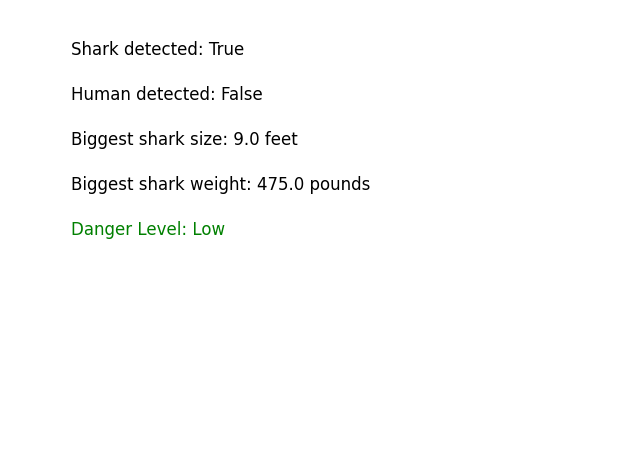

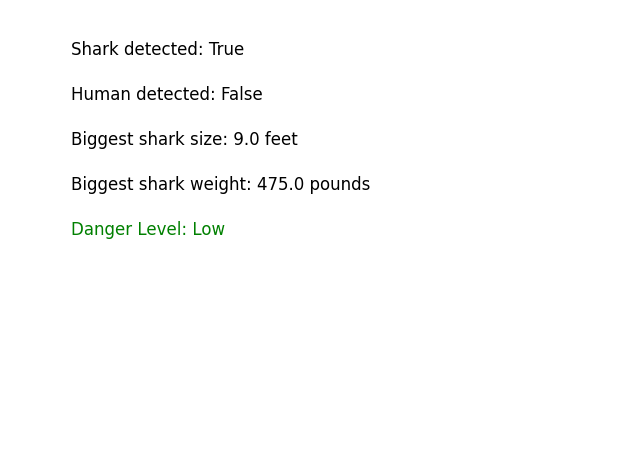

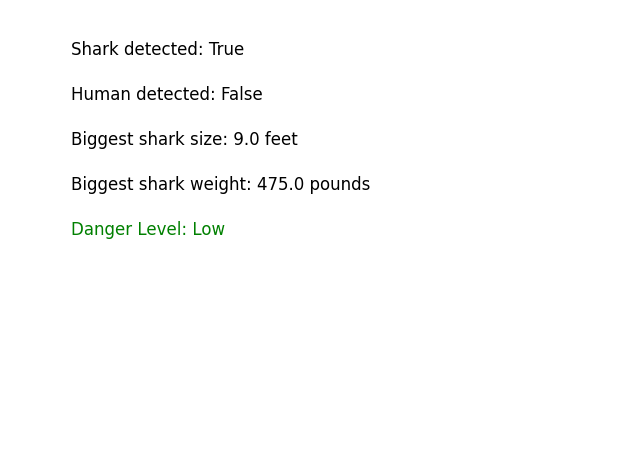

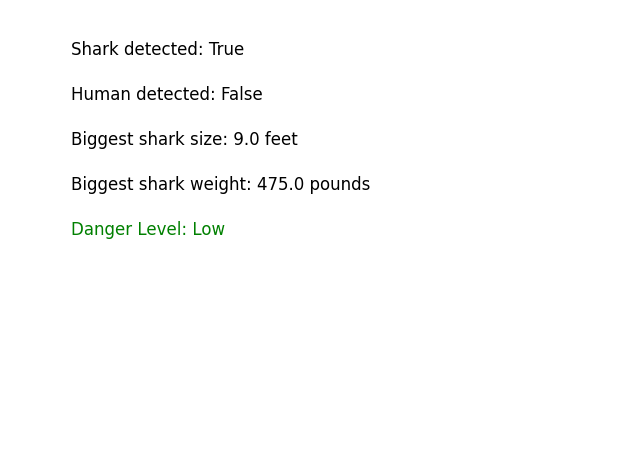

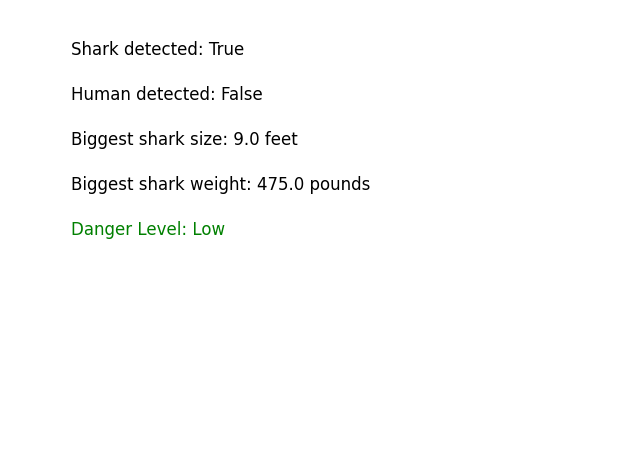

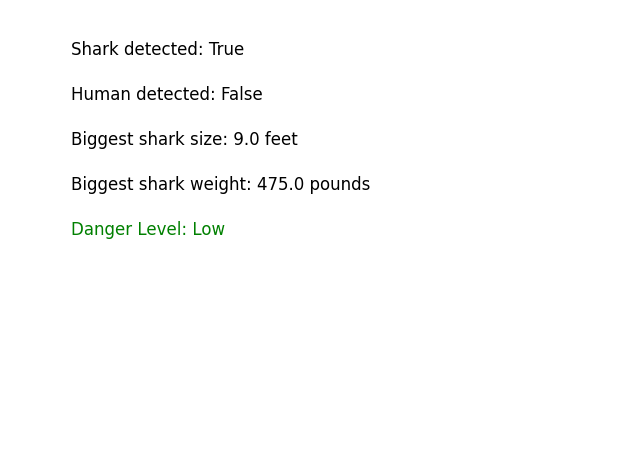

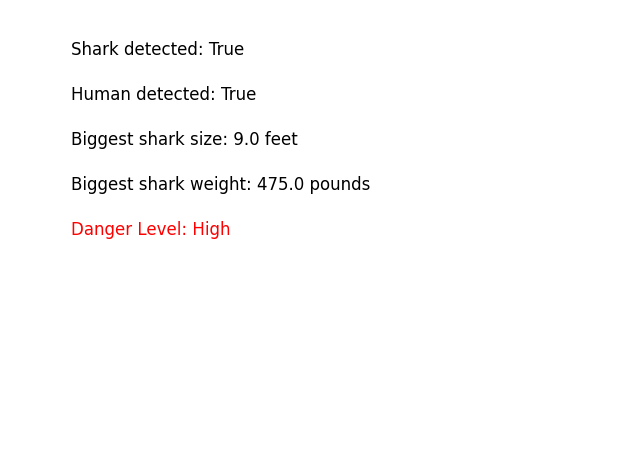

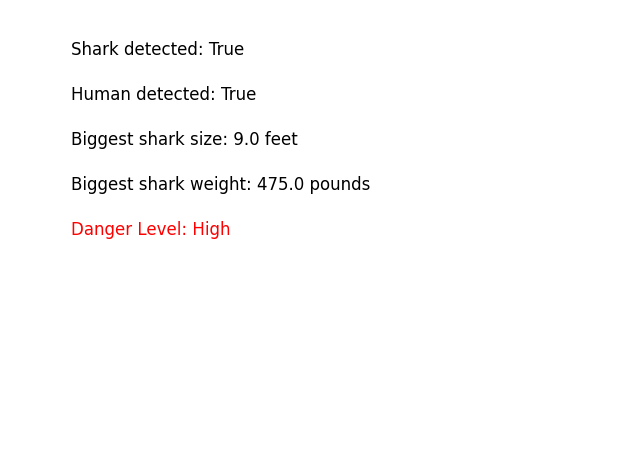

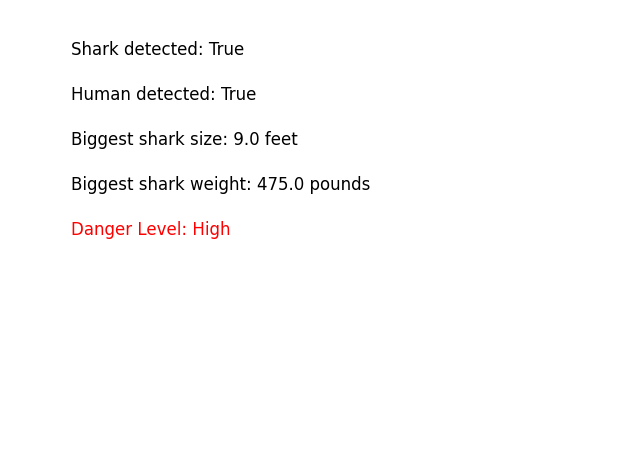

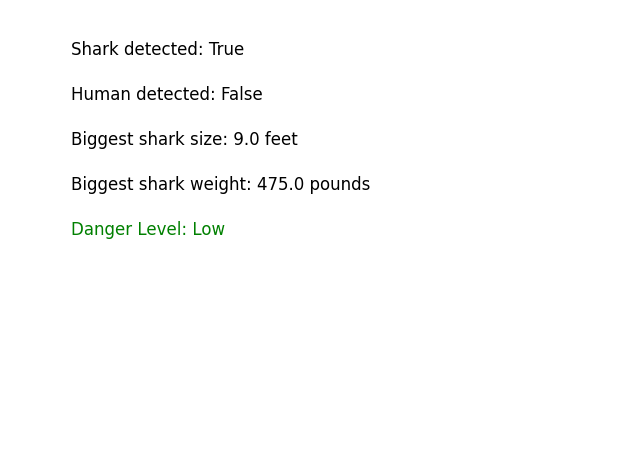

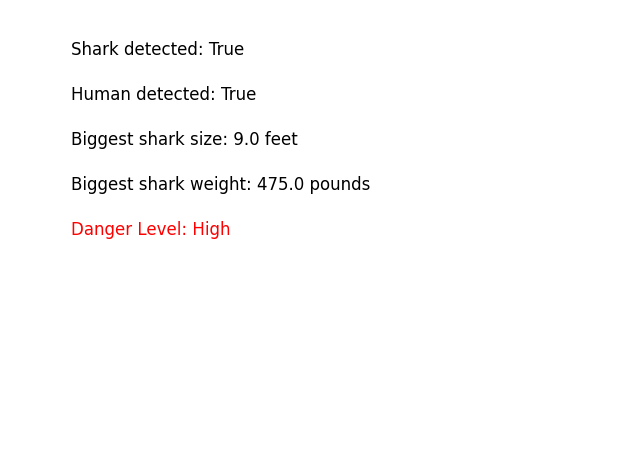

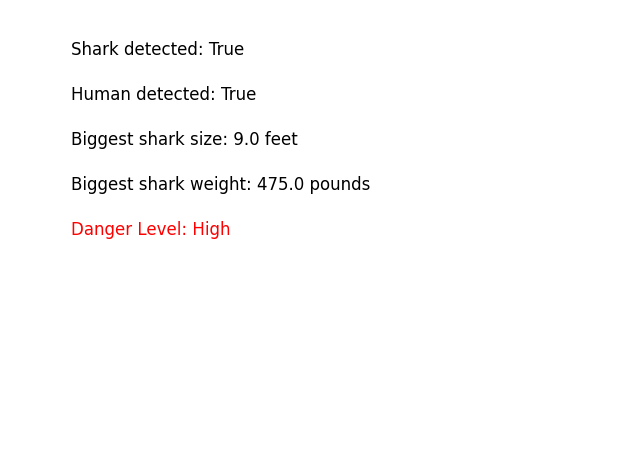

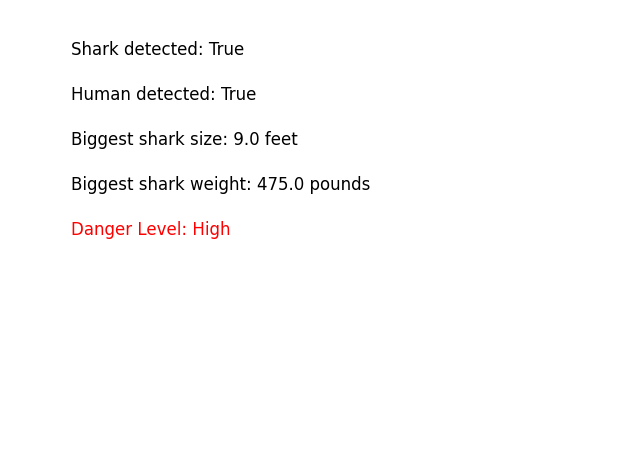

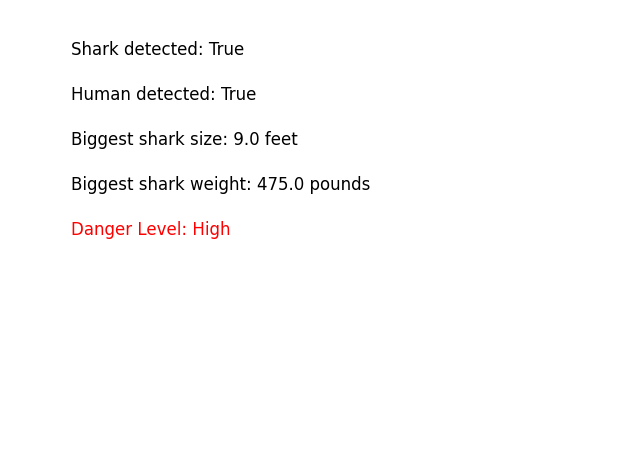

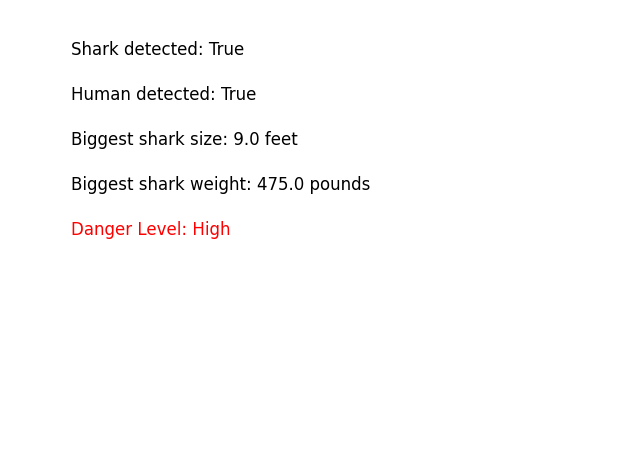

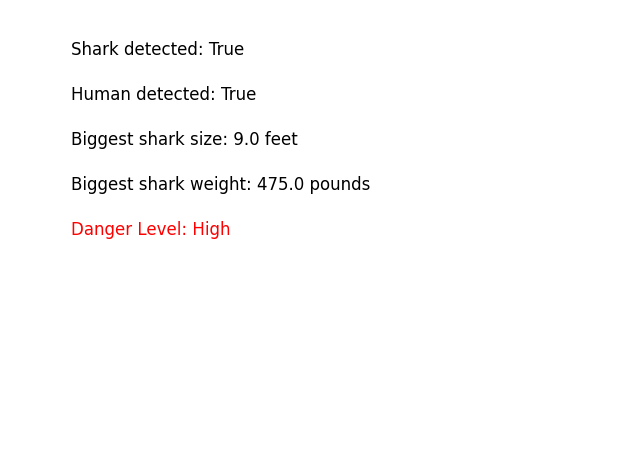

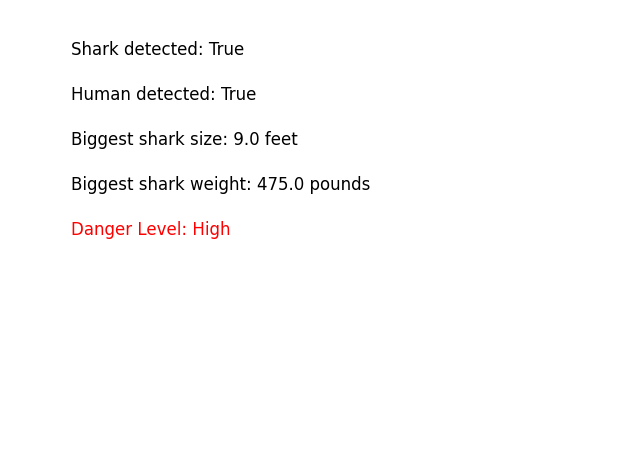

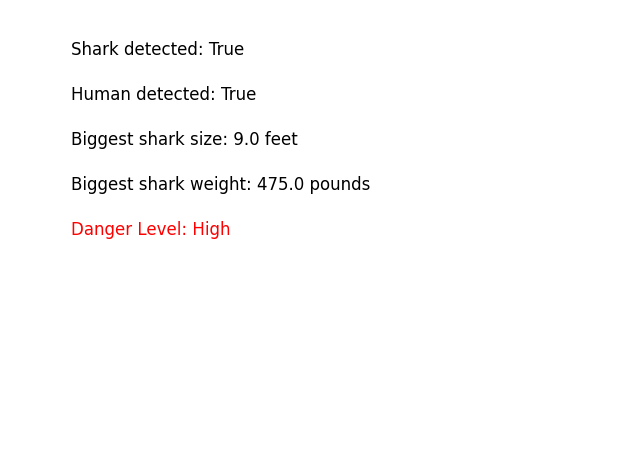

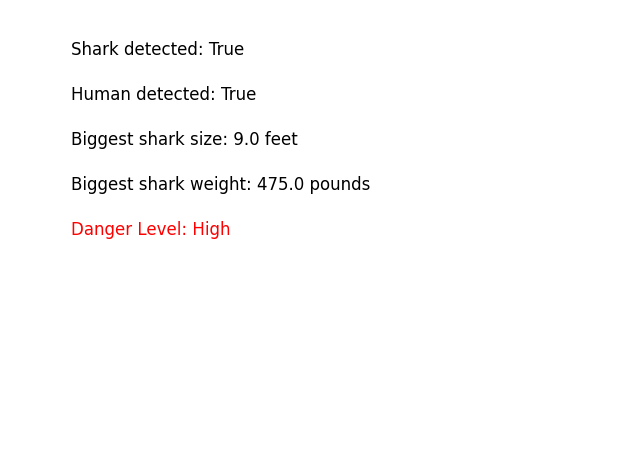

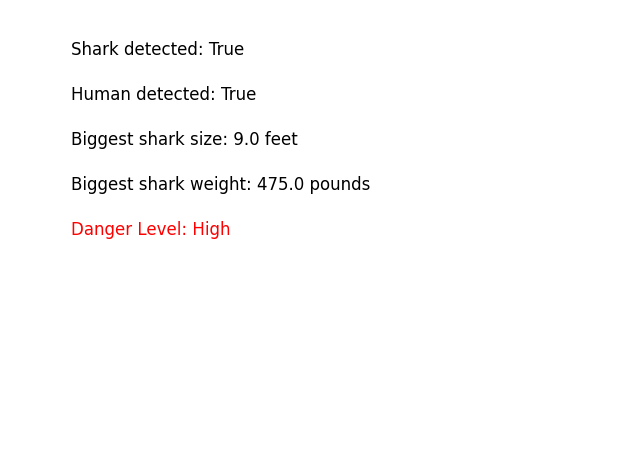

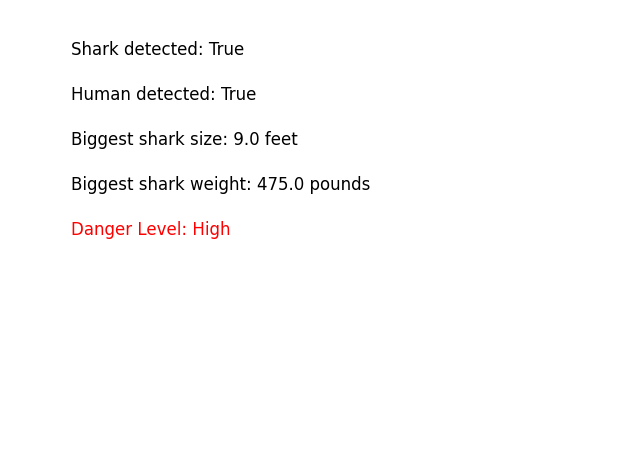

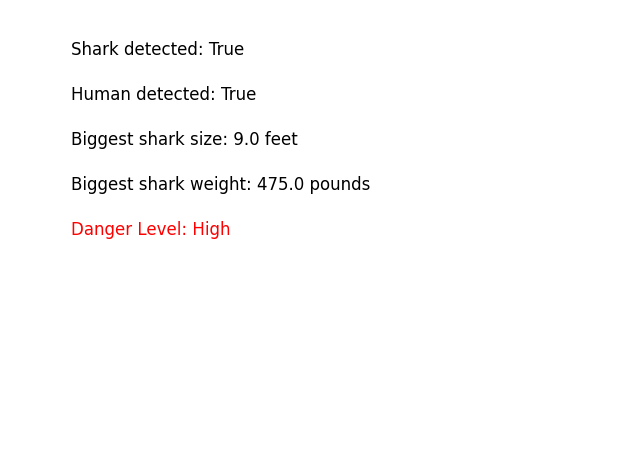

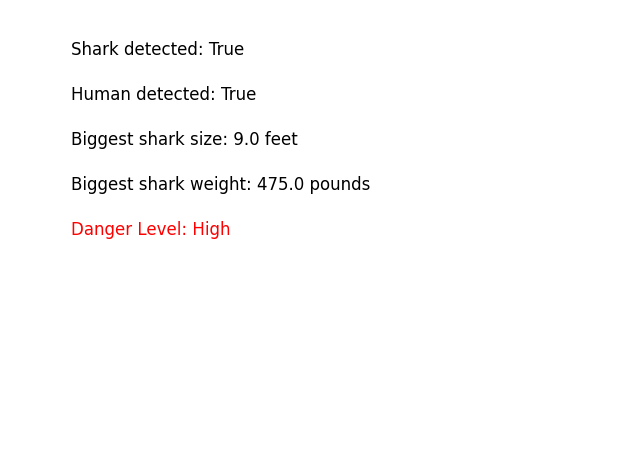

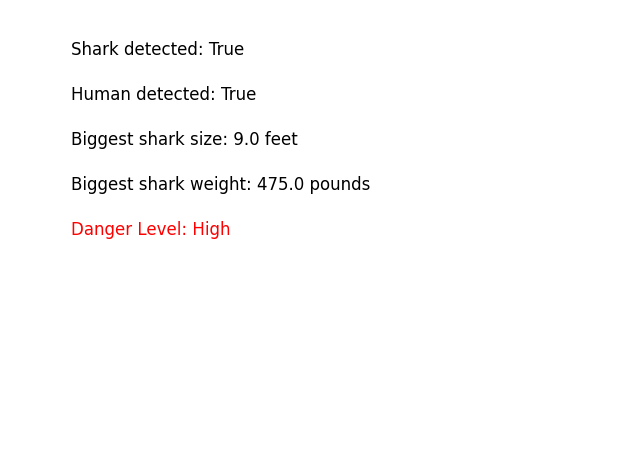

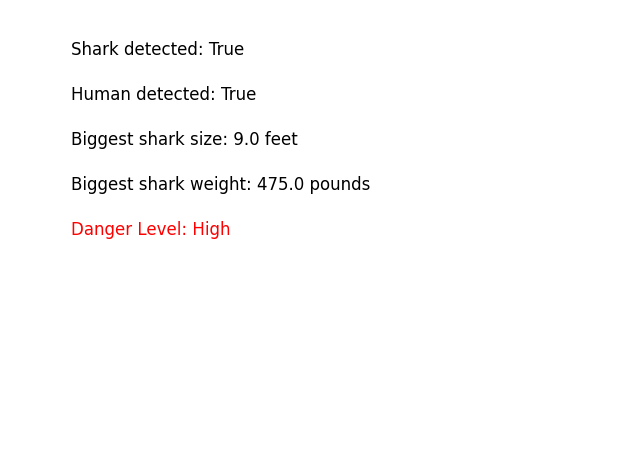

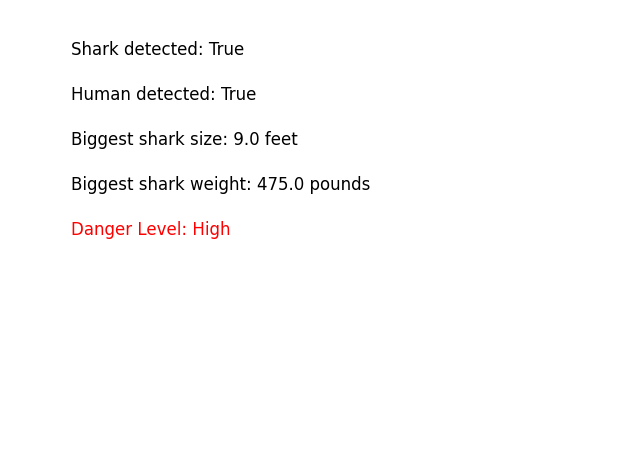

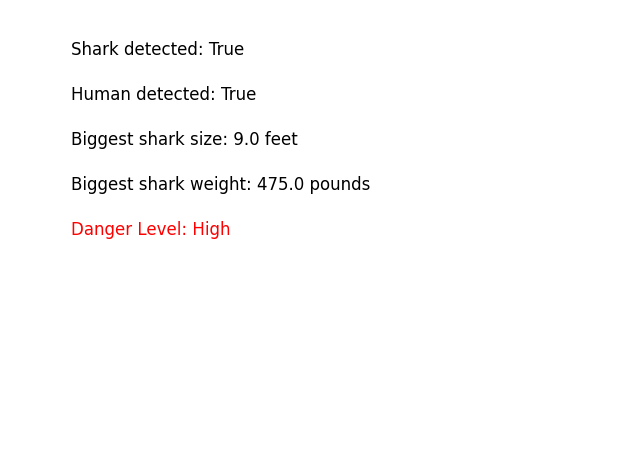

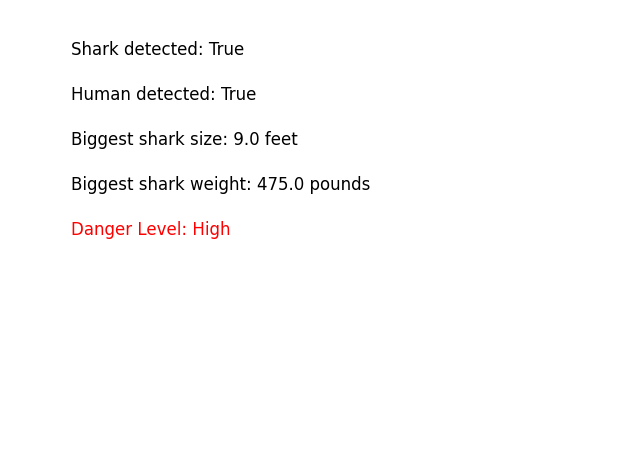

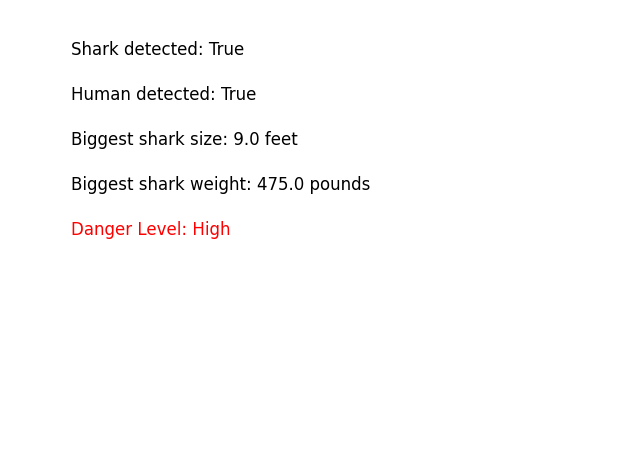

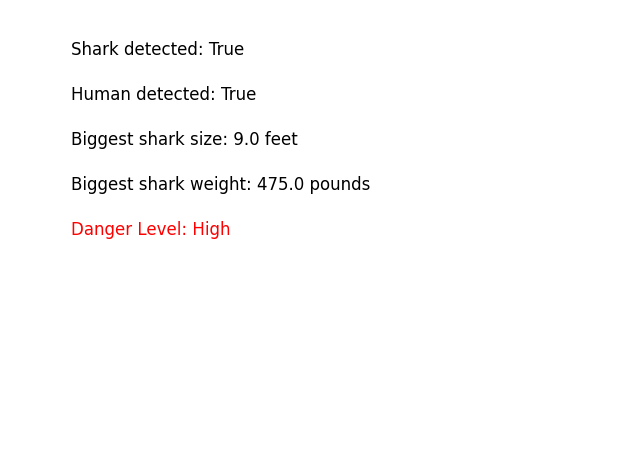

In [111]:
# predictions, frames = process_video('videos_example/421.mp4')

for i in range(30):
    start = time()
    top_pred = process_results_for_plot(predictions = predictions[i], threshold = 0.5, classes = classes, 
                                        class_sizes = class_sizes_lower, dangerous_distance = 100)
    fig_mat = prediction_dashboard(top_pred=top_pred)
    # plt.imshow(fig_mat)
    print(time() - start)

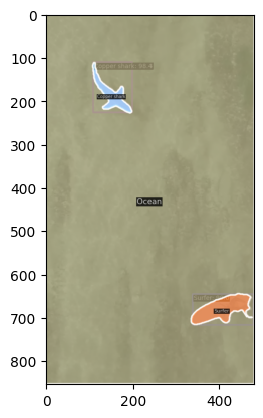

In [85]:
display_frame = inference_frame_serial(frames[36])
plt.imshow(display_frame[0])

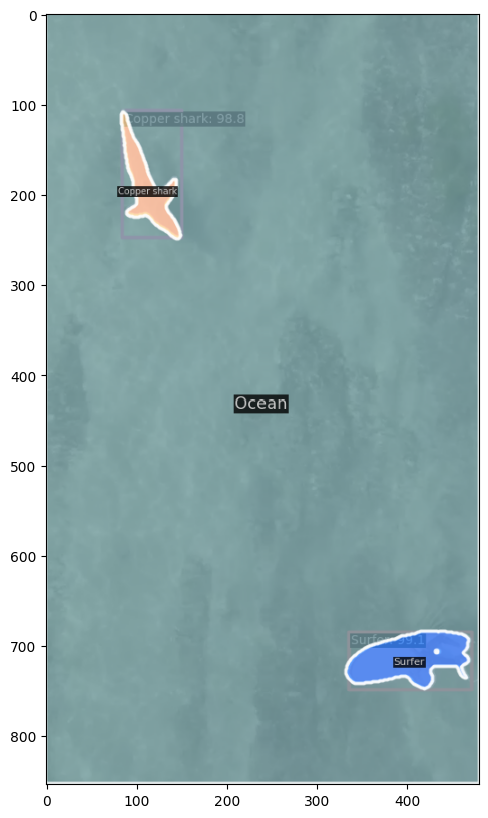

In [37]:
ax, fig = plt.subplots(1,1, figsize=(10,10))
vis_out = get_visualization_from_frame(frames[30], predictions[30])
plt.imshow(vis_out)